In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib import cm
import libertem
from libertem import api

In [3]:
%precision 4

'%.4f'

In [4]:
ctx = api.Context()

In [5]:
data_base_path = os.environ.get("TESTDATA_BASE_PATH", "/home/alex/Data/")

In [6]:
ds = ctx.load(
    "auto",
    path=os.path.join(data_base_path, "EMPAD/acquisition_12_full.xml"),
)
(scan_y, scan_x, detector_y, detector_x) = ds.shape
mask_shape = np.array((detector_y, detector_x))
cx = detector_x/2
cy = detector_y/2
y = scan_y//2
x = scan_x//2

In [7]:
pick_analysis = ctx.create_pick_analysis(dataset=ds, x=x, y=y)

In [8]:
%time pick_result = ctx.run(pick_analysis, progress=True)

Partitions 0/1, Frames:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 3.24 s, sys: 740 ms, total: 3.98 s
Wall time: 7.94 s


In [9]:
print(pick_result)

[<AnalysisResult: intensity>, <AnalysisResult: intensity_lin>]


In [10]:
# NBVAL_IGNORE_OUTPUT
print(pick_result.intensity)

title: intensity [log]
desc: the frame at x=128 y=128 log-scaled
key: intensity
raw_data: [[-8.1389e+00  2.7839e+02  1.2186e+02 ... -4.4079e+00  9.1751e+00
   3.6139e+02]
 [ 3.3432e+02  8.8130e+01  1.3434e+01 ...  5.2451e+00  3.8717e+02
   3.1518e+02]
 [ 1.8974e+02  4.5217e+02  2.1674e+02 ...  5.0107e-02  2.2460e+00
   6.6428e+01]
 ...
 [ 1.9781e+00 -1.1610e+00  3.7980e+00 ... -1.3129e+00 -4.0329e+00
   8.7018e+01]
 [ 3.9335e+02  1.7177e+01 -4.5100e+00 ...  4.2446e+02  7.2101e+00
  -8.6286e-01]
 [ 3.9165e+02  1.7034e+01 -5.5129e+00 ...  4.2316e+02  6.5401e+00
  -7.0392e-01]]
visualized: [[[ 48 128 126 255]
  [121 166  82 255]
  [ 82 157  72 255]
  ...
  [ 50 131 120 255]
  [ 56 137 106 255]
  [131 169  84 255]]

 [[128 168  83 255]
  [ 69 153  72 255]
  [ 57 139 103 255]
  ...
  [ 54 136 110 255]
  [133 169  84 255]
  [126 167  83 255]]

 [[104 163  78 255]
  [140 171  85 255]
  [109 163  79 255]
  ...
  [ 52 133 115 255]
  [ 53 134 112 255]
  [ 66 151  78 255]]

 ...

 [[ 53 134 112 2

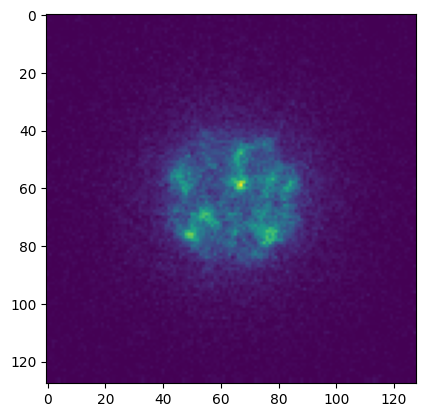

In [11]:
fig, axes = plt.subplots()
axes.imshow(pick_result.intensity.raw_data)

In [12]:
def all_ones():
    return np.ones((detector_y, detector_x))

In [13]:
def single_pixel():
    buf = np.zeros((detector_y, detector_x))
    buf[int(cy), int(cx)] = 1
    return buf

Here we use a mask UDF. This UDF uses the LiberTEM computation rather directly and returns a simple numerical result. See further below for examples that use the high-level analysis interface instead.

In [14]:
mask_udf = libertem.udf.masks.ApplyMasksUDF(mask_factories=[all_ones, single_pixel])

In [15]:
%%time
mask_udf_result = ctx.run_udf(dataset=ds, udf=mask_udf, progress=True)

Partitions 0/24, Frames:   0%|          | 0/65536 [00:00<?, ?it/s]

CPU times: user 1.01 s, sys: 484 ms, total: 1.49 s
Wall time: 9.54 s


In [16]:
print(mask_udf_result)

{'intensity': <BufferWrapper kind=nav dtype=float64 extra_shape=(2,)>}


In [17]:
print(mask_udf_result['intensity'])

<BufferWrapper kind=nav dtype=float64 extra_shape=(2,)>


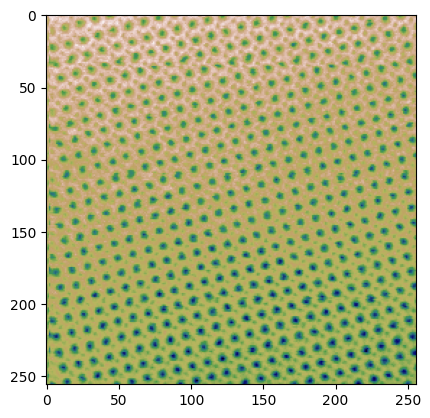

In [18]:
fig, axes = plt.subplots()
axes.imshow(mask_udf_result['intensity'].data[..., 0], cmap=cm.gist_earth)

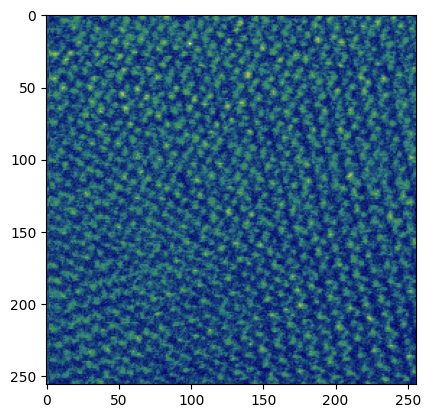

In [19]:
fig, axes = plt.subplots()
axes.imshow(mask_udf_result['intensity'].data[..., 1], cmap=cm.gist_earth)

In [20]:
mask_analysis = ctx.create_mask_analysis(dataset=ds, factories=[all_ones, single_pixel])

In [21]:
%time mask_analysis_result = ctx.run(mask_analysis, progress=True)

Partitions 0/24, Frames:   0%|          | 0/65536 [00:00<?, ?it/s]

CPU times: user 188 ms, sys: 43.5 ms, total: 232 ms
Wall time: 540 ms


In [22]:
print(mask_analysis_result)

[<AnalysisResult: mask_0>, <AnalysisResult: mask_1>]


In [23]:
# NBVAL_IGNORE_OUTPUT
print(mask_analysis_result[0])

title: mask 0
desc: integrated intensity for mask 0
key: mask_0
raw_data: [[27850324.4647 28474082.4509 29206838.6794 ... 28496849.7669
  28388546.927  28217773.007 ]
 [28612171.7066 28955478.9061 29521825.3989 ... 28629364.4383
  28697176.7665 28371276.0654]
 [28774531.5103 28422556.4079 29332136.6659 ... 28734413.2553
  28855773.9464 28983199.2062]
 ...
 [26167279.0255 27059745.2544 27660706.177  ... 27118113.3879
  27208242.4221 27266392.256 ]
 [26604566.9983 27274427.7075 27053773.3009 ... 26818205.9628
  26966513.0464 26932802.8792]
 [26721508.9678 27176442.751  26789558.9248 ... 26511140.4287
  27037473.0653 27278705.8884]]
visualized: [[[186 175  96 255]
  [200 166 120 255]
  [229 199 187 255]
  ...
  [201 167 123 255]
  [197 164 113 255]
  [191 164 100 255]]

 [[206 171 132 255]
  [219 183 162 255]
  [241 222 220 255]
  ...
  [207 172 135 255]
  [209 173 140 255]
  [197 164 113 255]]

 [[212 176 147 255]
  [198 165 115 255]
  [235 209 202 255]
  ...
  [211 175 145 255]
  [216 1

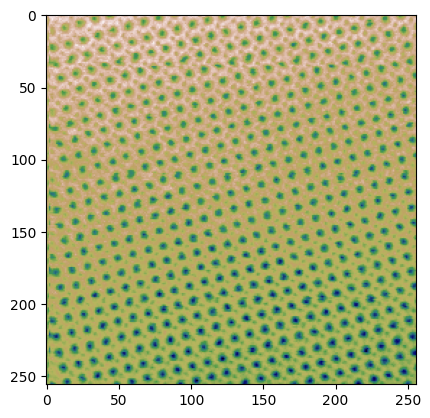

In [24]:
fig, axes = plt.subplots()
axes.imshow(mask_analysis_result[0].visualized)

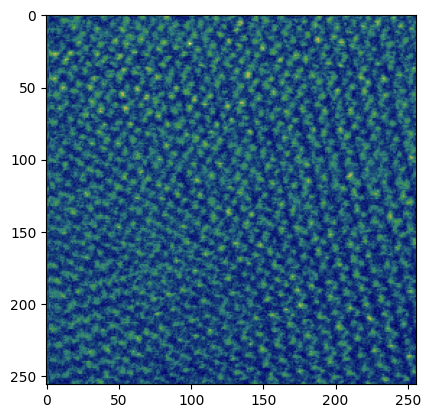

In [25]:
fig, axes = plt.subplots()
axes.imshow(mask_analysis_result[1].visualized)

In [26]:
ro = min(detector_x,detector_y)/2
haadf_analysis = ctx.create_ring_analysis(dataset=ds, cx=cx, cy=cy, ro=ro, ri=ro*0.8)

In [27]:
%time haadf_result = ctx.run(haadf_analysis, progress=True)

Partitions 0/24, Frames:   0%|          | 0/65536 [00:00<?, ?it/s]

CPU times: user 110 ms, sys: 20.4 ms, total: 130 ms
Wall time: 127 ms


In [28]:
print(haadf_result)

[<AnalysisResult: intensity>, <AnalysisResult: intensity_log>]


In [29]:
# NBVAL_IGNORE_OUTPUT
print(haadf_result.intensity)

title: intensity [lin]
desc: intensity of the integration over the selected ring lin-scaled
key: intensity
raw_data: [[1.4305e+06 1.4726e+06 1.3319e+06 ... 1.4070e+06 1.4413e+06 1.4646e+06]
 [1.3907e+06 1.4412e+06 1.3478e+06 ... 1.3029e+06 1.3140e+06 1.3479e+06]
 [1.4071e+06 1.5642e+06 1.4447e+06 ... 1.3969e+06 1.3214e+06 1.3175e+06]
 ...
 [1.9052e+06 1.7065e+06 1.6203e+06 ... 1.7924e+06 1.7859e+06 1.7521e+06]
 [1.7952e+06 1.6514e+06 1.6752e+06 ... 1.8672e+06 1.8337e+06 1.8207e+06]
 [1.7582e+06 1.6667e+06 1.6918e+06 ... 1.9187e+06 1.8127e+06 1.7762e+06]]
visualized: [[[ 38 105 125 255]
  [ 43 118 126 255]
  [ 25  69 121 255]
  ...
  [ 35  97 124 255]
  [ 39 109 125 255]
  [ 43 116 126 255]]

 [[ 33  92 123 255]
  [ 39 109 125 255]
  [ 27  75 121 255]
  ...
  [ 21  56 120 255]
  [ 22  60 120 255]
  [ 27  75 121 255]]

 [[ 35  97 124 255]
  [ 54 135 111 255]
  [ 40 110 125 255]
  ...
  [ 33  94 123 255]
  [ 23  64 121 255]
  [ 23  62 120 255]]

 ...

 [[145 172  86 255]
  [ 67 152  76 25

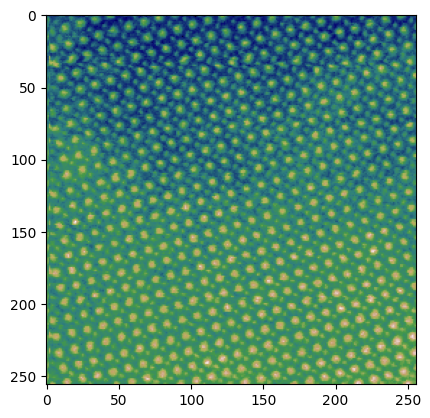

In [30]:
fig, axes = plt.subplots()
axes.imshow(haadf_result.intensity.visualized)

In [31]:
bf_analysis = ctx.create_disk_analysis(dataset=ds, cx=cx, cy=cy, r=ro*0.3)

In [32]:
%time bf_result = ctx.run(bf_analysis, progress=True)

Partitions 0/24, Frames:   0%|          | 0/65536 [00:00<?, ?it/s]

CPU times: user 255 ms, sys: 16.5 ms, total: 272 ms
Wall time: 270 ms


In [33]:
print(bf_result)

[<AnalysisResult: intensity>, <AnalysisResult: intensity_log>]


In [34]:
# NBVAL_IGNORE_OUTPUT
print(bf_result.intensity)

title: intensity [lin]
desc: intensity of the integration over the selected disk lin-scaled
key: intensity
raw_data: [[1.1856e+07 1.2051e+07 1.3057e+07 ... 1.2369e+07 1.1876e+07 1.1599e+07]
 [1.2860e+07 1.2649e+07 1.3450e+07 ... 1.2338e+07 1.2118e+07 1.1864e+07]
 [1.3009e+07 1.1590e+07 1.2700e+07 ... 1.2133e+07 1.2087e+07 1.2034e+07]
 ...
 [9.9259e+06 1.0641e+07 1.1301e+07 ... 1.0897e+07 1.1076e+07 1.1225e+07]
 [1.0471e+07 1.1345e+07 1.0838e+07 ... 1.0156e+07 1.0719e+07 1.0771e+07]
 [1.0752e+07 1.1300e+07 1.0409e+07 ... 9.7664e+06 1.0741e+07 1.0775e+07]]
visualized: [[[173 180  92 255]
  [181 182  93 255]
  [199 166 118 255]
  ...
  [186 175  96 255]
  [173 180  92 255]
  [159 176  89 255]]

 [[192 163 103 255]
  [190 168  99 255]
  [212 176 147 255]
  ...
  [186 175  96 255]
  [183 181  94 255]
  [173 180  92 255]]

 [[198 165 115 255]
  [159 176  89 255]
  [190 167  99 255]
  ...
  [183 181  94 255]
  [182 182  94 255]
  [181 182  93 255]]

 ...

 [[ 67 152  76 255]
  [111 164  79 25

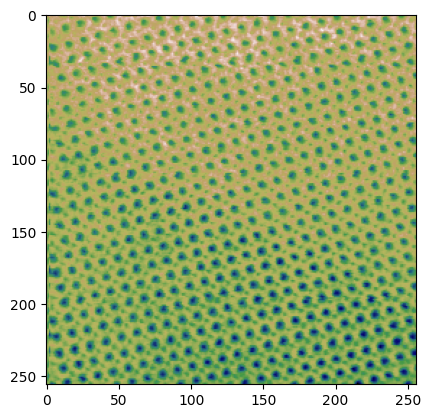

In [35]:
fig, axes = plt.subplots()
axes.imshow(bf_result.intensity.visualized)

In [36]:
point_analysis = ctx.create_point_analysis(dataset=ds, x=cx, y=cy)

In [37]:
%time point_result = ctx.run(point_analysis, progress=True)

Partitions 0/24, Frames:   0%|          | 0/65536 [00:00<?, ?it/s]

CPU times: user 342 ms, sys: 182 ms, total: 524 ms
Wall time: 2.47 s


In [38]:
print(point_result)

[<AnalysisResult: intensity>, <AnalysisResult: intensity_log>]


In [39]:
# NBVAL_IGNORE_OUTPUT
print(point_result.intensity)

title: intensity [lin]
desc: intensity of the integration over the selected point lin-scaled
key: intensity
raw_data: [[ 9863.201  11829.065   6490.724  ...  7891.671   6461.673   6609.272 ]
 [11411.631  13569.099   7547.4136 ...  8430.884   8433.084   4680.7437]
 [10615.64   10571.748   7038.782  ... 12167.771   7040.497   7997.6006]
 ...
 [ 7091.531  11770.922   7214.841  ...  5467.903   5994.1973  6137.106 ]
 [ 7214.639  15155.479   8181.688  ...  5985.63    6306.6313  6185.5386]
 [10637.375  13987.006   5301.716  ...  4848.8687  6378.0674  6715.919 ]]
visualized: [[[ 30  84 122 255]
  [ 37 104 124 255]
  [ 17  45 119 255]
  ...
  [ 23  62 120 255]
  [ 17  43 119 255]
  [ 17  45 119 255]]

 [[ 36 101 124 255]
  [ 44 120 126 255]
  [ 21  58 120 255]
  ...
  [ 25  69 121 255]
  [ 25  69 121 255]
  [ 10  20 117 255]]

 [[ 33  92 123 255]
  [ 33  92 123 255]
  [ 19  52 119 255]
  ...
  [ 39 107 125 255]
  [ 19  52 119 255]
  [ 23  62 120 255]]

 ...

 [[ 19  52 119 255]
  [ 37 104 124 2

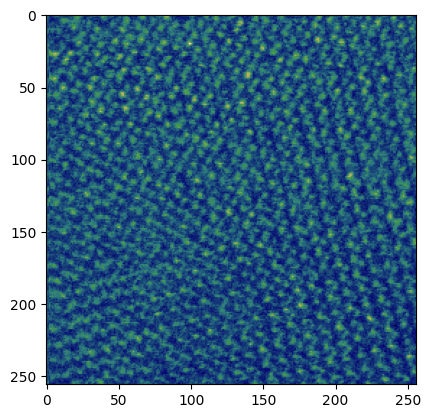

In [40]:
fig, axes = plt.subplots()
axes.imshow(point_result.intensity.visualized)

In [41]:
sum_analysis = ctx.create_sum_analysis(dataset=ds)

In [42]:
%time sum_result = ctx.run(sum_analysis, progress=True)

Partitions 0/24, Frames:   0%|          | 0/65536 [00:00<?, ?it/s]

CPU times: user 161 ms, sys: 33 ms, total: 194 ms
Wall time: 580 ms


In [43]:
print(sum_result)

[<AnalysisResult: intensity>, <AnalysisResult: intensity_lin>]


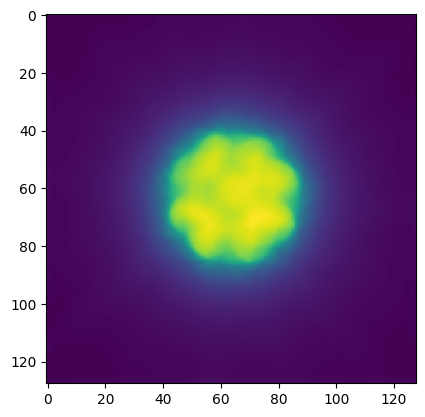

In [44]:
fig, axes = plt.subplots()
axes.imshow(sum_result.intensity.raw_data)